In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import decomposition
from sklearn import model_selection
from sklearn import metrics
from sklearn import svm


from matplotlib import pyplot as plt
%matplotlib inline

# IO utils


In [2]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [3]:
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)
df_meta

,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
1,2023-05-15_17-12-24.palm,1,23336,23336,5803
2,2023-06-05_16-12-38.palm,1,17939,17939,4431
3,2023-06-05_17-53-01.palm,1,17771,17771,4435
4,2023-06-20_14-43-11.palm,1,17936,17936,4441
5,2023-06-20_13-30-15.palm,1,17928,17928,4435
6,2023-06-20_12-34-17.palm,1,17758,17758,4444
7,2023-09-30_08-06-44.palm,2,5693,5693,5509
8,2023-09-29_11-03-50.palm,2,5694,5694,5511
9,2023-09-29_09-20-47.palm,2,5690,5690,5507


In [4]:
palm_file = './data/2023-05-05_17-57-30.palm'
gestures = read_omg_csv(
    palm_file, 
    n_omg_channels=50,
    n_acc_channels=3, 
    n_gyr_channels=3, 
    n_enc_channels=6, 
    n_mag_channels=0
)

print(gestures.shape)
gestures.head()

(26648, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,0,11,58,3462,3692,3417,1868,13,7,5,...,-1,0,0,0,0,0,0,0,0,161823
1,10,8,51,3463,3693,3418,1870,21,6,6,...,4,0,0,0,0,0,0,0,0,161856
2,11,9,58,3463,3692,3418,1871,13,6,6,...,6,0,0,0,0,0,0,0,0,161889
3,11,8,58,3460,3692,3418,1869,13,6,5,...,7,0,0,0,0,0,0,0,0,161922
4,24,8,58,3460,3691,3417,1856,13,7,12,...,8,0,0,0,0,0,0,0,0,161955


In [5]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [6]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


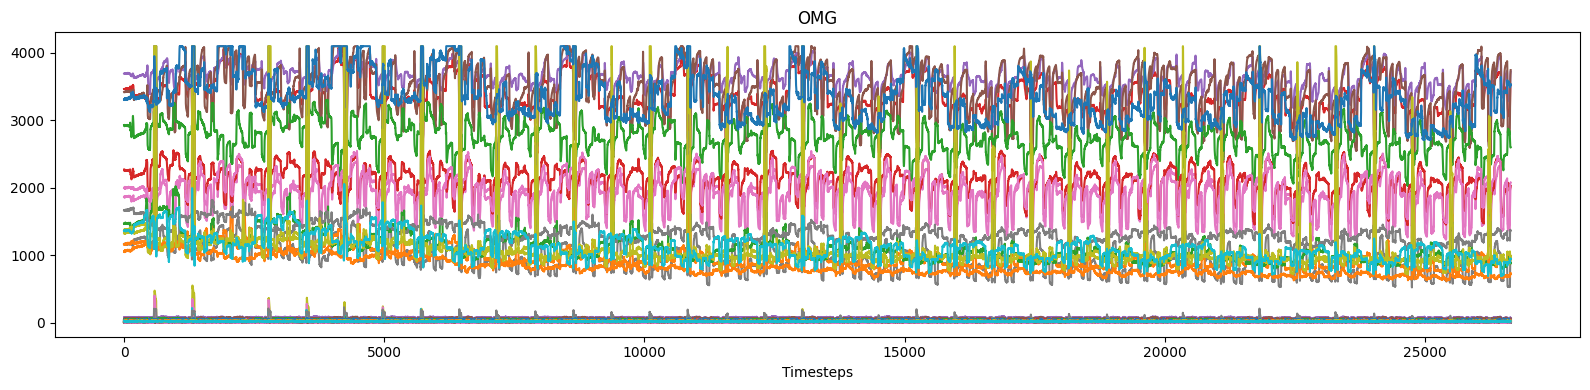

In [7]:
fig = plt.figure(figsize=(16, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

### Protocol

In [8]:
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
print('Shape of data:', gestures_protocol.shape)
gestures_protocol.head()

Shape of data: (217, 11)


,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [9]:
le = preprocessing.LabelEncoder()

# FIT
le.fit(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

# TRANSFORM
gestures_protocol['gesture'] = le.transform(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)
    
display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

In [10]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [11]:
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
y_cmd

array([0, 0, 0, ..., 0, 0, 0])

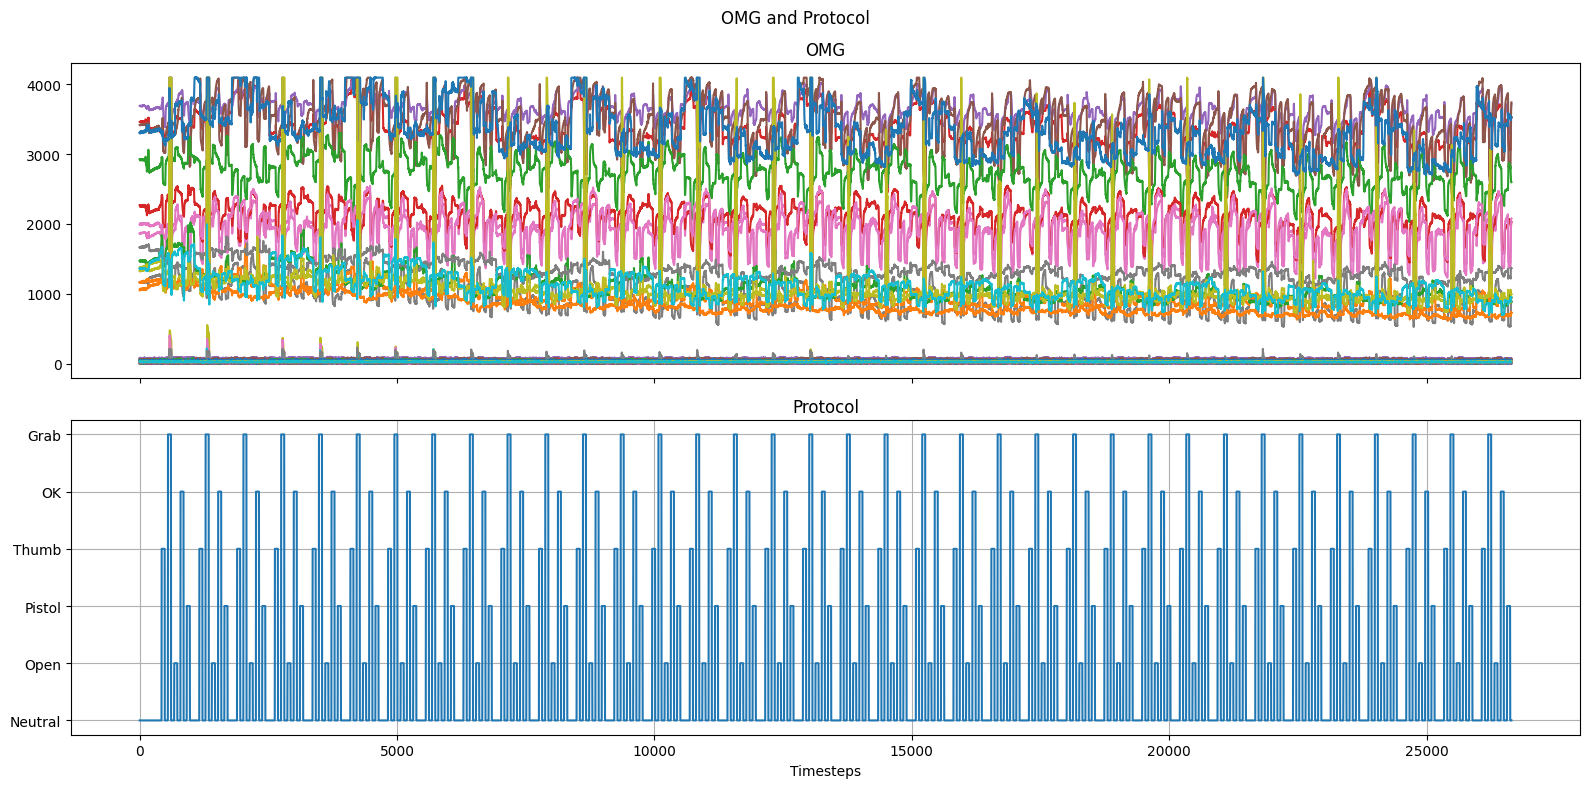

In [12]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(16, 8))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

---
---
---
---
---

# Preprocessing

In [13]:
# Функция для отрисовки графики "OMG and Protocol" для заданного интервала
def get_graphs(X_array, y_array, start=1000, end=1500):
    
    _, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
    plt.suptitle(f'OMG and Protocol {start}:{end}')
    ax1.plot(X_array[start:end])
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('OMG')
    plt.grid(axis='x')
    ax2 = ax1.twinx()
    ax2.plot(y_array[start:end], 'b-')
    ax2.set_ylabel('y_cmd')
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.show()

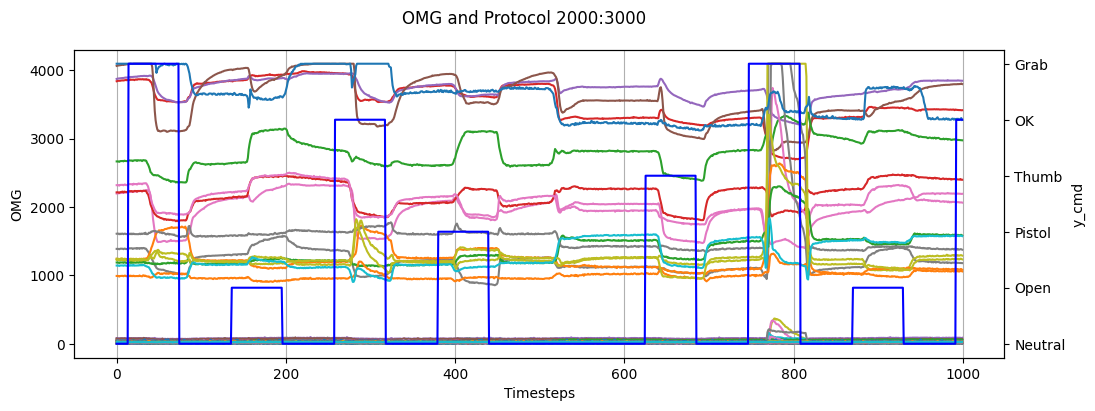

In [14]:
get_graphs(gestures[OMG_CH].values, y_cmd, start=2000, end=3000)

## Глобальное устранение лага между сигналами датчиков и таргетом

In [15]:
def get_naive_centering(X_arr, y_arr, gap=500, inter=1000, window=20, use_m=True, model=svm.SVC()):
    """Функция для устранения глобального лага между сигналами датчиков и таргетом.

    Args:
        X_arr (ndarray): Массив данных.
        y_arr (ndarray): Вектор целевого признака.
        gap (int, optional): Размеры концевых отступов. Defaults to 500.
        inter (int, optional): Величина концевых выборок. Defaults to 1000.
        window (int, optional): Величина окна поиска оптимального сдвига. Defaults to 20.
        use_m (bool, optional): Использование модели для поиска оптимального сдвига.
            Defaults to True. False: поиск сдвига по корреляции таргета с вектором
            суммы модулей дифференциалов векторов признаков массива данных.
        model (_type_, optional): Алгоритм scikit-learn. Defaults to svm.SVC().

    Returns:
        tuple():
            ndarray: Вектор сдвинутого таргета.
            list: Строки отчета по проделанным операциям.
    """
    # part of the data from the beginning
    X_part1 = X_arr[gap:gap+inter]
    y_part1 = y_arr[gap:gap+inter]
    # part of the data from the end
    X_part2 = X_arr[-gap-inter:-gap]
    y_part2 = y_arr[-gap-inter:-gap]
    
    # Функция для сдвига таргета
    def shifter(y_arr, shift=1):
        first_element = y_arr[0]
        prefix = np.full(shift, first_element)
        y_arr_shifted = np.concatenate((prefix, y_arr))[:-shift]
    
        return y_arr_shifted
    
    # Функция для расчета точности модели
    def get_score(X, y, model=model):
        model = model
        model.fit(X, y)
        preds = model.predict(X)
        
        return metrics.accuracy_score(y, preds)
    
    # Функция для расчета корреляции
    def get_corr(X, y):
        x_diff = pd.DataFrame(X).diff().abs().sum(axis=1)
        correlation = np.corrcoef(x_diff, y)[0, 1]
        
        return abs(correlation)
    
    
    max_score1, current_score1 = 0, 0
    max_score2, current_score2 = 0, 0
    s1, s2 = 1, 1
    
    for i in range(1, window+1):
        y_a = shifter(y_part1, shift=i)
        y_b = shifter(y_part2, shift=i)
        
        if use_m:
            current_score1 = get_score(X_part1, y_a)
            current_score2 = get_score(X_part2, y_b)
        else:
            current_score1 = get_corr(X_part1, y_a)
            current_score2 = get_corr(X_part2, y_b)
        
        if current_score1 > max_score1:
            max_score1, current_score1 = current_score1, max_score1
            s1 = i
        
        if current_score2 > max_score2:
            max_score2, current_score2 = current_score2, max_score2
            s2 = i
    
    optimal_shift = round((s1+s2)/2)
    y_arr_shifted = shifter(y_arr, shift=optimal_shift)
    summary = [
        f'Оптимальные свдиги для концевых выборок:   {s1} и {s2}\n',
        f'Accuracy/correlation на концевых выборках: {max_score1}; {max_score2}\n',
        f'Размер оптимального сдвига (как среднего): {optimal_shift}'
    ]
    
    return y_arr_shifted, summary

In [16]:
X = gestures[OMG_CH].values
# fitting_model = svm.LinearSVC(dual='auto')
y_shifted, summary = get_naive_centering(X, y_cmd, inter=500, window=30, use_m=False) # model=fitting_model
print(*summary, sep='')

Оптимальные свдиги для концевых выборок:   18 и 15
Accuracy/correlation на концевых выборках: 0.38132155722125555; 0.31151200013560987
Размер оптимального сдвига (как среднего): 16


Посмотрим на результат.

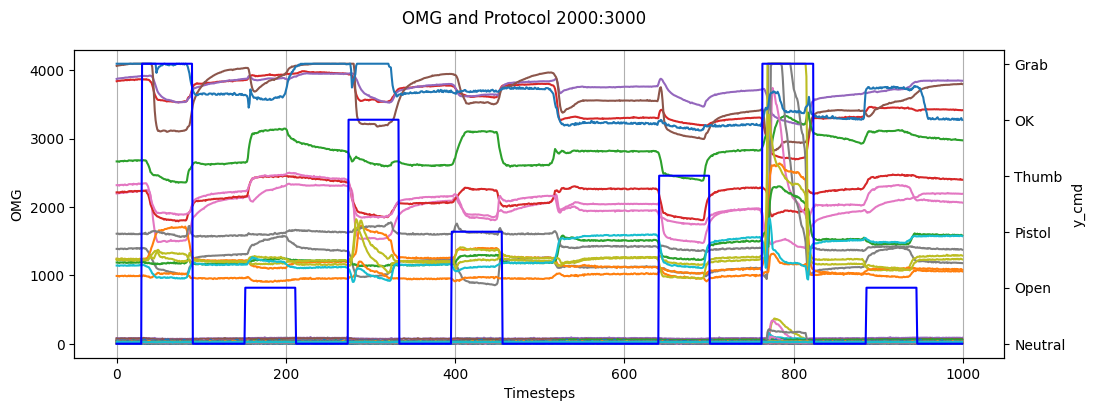

In [17]:
get_graphs(X, y_shifted, start=2000, end=3000)

## Сэмплирование

In [18]:
last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']

X_train = X[:last_train_idx]
y_train = y_shifted[:last_train_idx]

X_test = X[last_train_idx:]
y_test = y_shifted[last_train_idx:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(20756, 50) (20756,)
(5892, 50) (5892,)


## Корреляционный анализ

In [26]:
def find_highly_correlated_features(data, threshold=0.9):
    """Функция корреляционного анализа

    Args:
        data (ndarray): Массив данных.
        threshold (float, optional): Порог корреляции. Defaults to 0.9.

    Returns:
        tuple:
            list: Спсиок пар номеров высоко скореллированных признаков.
            set: Множество оптимально-отобранных номеров признаков из
                высоко скореллированных пар.
    """
    # Строим корреляционную матрицу
    corr_matrix = np.corrcoef(data, rowvar=False)
    
    # Находим индексы нижнего треугольника корреляционной матрицы
    lower_triangle_indices = np.tril_indices(corr_matrix.shape[0], k=-1)
    
    # Находим пары высоко скоррелированных признаков
    high_corr_features = [
        [j, i] for i, j in zip(
            lower_triangle_indices[0], lower_triangle_indices[1]
        ) if abs(corr_matrix[i, j]) > threshold
    ]

    hcf_copy = high_corr_features.copy()
    # Определяем features_to_remove
    features_to_remove = []
    while True:
        dct = {}
        for el in hcf_copy:
            for num in el:
                cnt = 0
                for l in hcf_copy:
                    if (num in l) and (len(l) == 2):
                        cnt += 1
                dct[num] = cnt
        
        if (len(set(dct.values())) == 1) and (list(dct.values())[0] == 0):
            break
        
        if not dct:
            break

        num_tb_dltd = max(dct, key=dct.get)
        features_to_remove.append(num_tb_dltd)

        hcf_copy = [
            [x for x in inner_list if x != num_tb_dltd]
            for inner_list in hcf_copy
        ]

    return high_corr_features, list(set(features_to_remove))

In [27]:
_, features_to_remove = find_highly_correlated_features(X_train)
features_to_remove

[26, 5, 28, 37]

Удалим высокоскореллированные признаки.

In [28]:
X_train_cd = np.delete(X_train, features_to_remove, axis=1)
X_test_cd = np.delete(X_test, features_to_remove, axis=1)

## Стандартизация

In [29]:
std_scaler = preprocessing.StandardScaler()

X_train_scaled = std_scaler.fit_transform(X_train_cd)
X_test_scaled = std_scaler.transform(X_test_cd)

## Устранение мультиколлинеарности

In [30]:
# Матрица корреляций
corr_mtrx = np.corrcoef(X_train_scaled.T)

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 46
Ранг матрицы:   46
Определитель:   2.287600422669724e-20


In [31]:
# Определяем метод таким образом, чтобы отобранные им
# компоненты объясняли не менее 99,99 % разброса данных
pca = decomposition.PCA(n_components=0.9999, random_state=42).fit(X_train_scaled)
# Обучаем алгоритм на наших данных
print(f'Число компонент: {len(pca.components_)}')

Число компонент: 46


In [32]:
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
# Матрица корреляций
corr_mtrx = np.corrcoef(X_train_pca.T)

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 46
Ранг матрицы:   46
Определитель:   0.9999999999999989


## Экспоненциальное сглаживаение

In [33]:
from scipy import signal

def get_convolve(data, M=10, tau=3, sym=True):
    win = signal.windows.exponential(M, tau=tau, sym=sym)
    data_result = np.zeros((data.shape[0]))
    for i in range(data.shape[1]):
        sig = data[:, i]
        filtered = signal.convolve(sig, win, mode='same') / sum(win)
        data_result = np.column_stack((data_result, filtered))
        
    return data_result[:, 1:]

In [34]:
X_train_ce = get_convolve(X_train_pca, M=10, tau=1, sym=False)
X_test_ce = get_convolve(X_test_pca, M=10, tau=1, sym=False)

In [253]:
# # Функция для экспоненциального сглаживания
# def get_smoothing(Xdf, sample_size=5, alpha=0.3):
#     """Функция для экспоненциального сглаживания

#     Args:
#         Xdf (ndarray): Массив данных.
#         sample_size (int, optional): Размер сглаживаемой выборки. Defaults to 5.
#         alpha (float, optional): Коэффициент сглаживания. Defaults to 0.3.

#     Returns:
#         ndarray: Преобразованный массив.
#     """
#     samples, j = [], 0
#     for i in range(sample_size, Xdf.shape[0] + 1, sample_size):
#         x_smoothed = Xdf.loc[j:i-1, list(Xdf.columns)].ewm(alpha=alpha, adjust=True).mean().values
#         samples.append(x_smoothed)
#         j = i
    
#     X_ewm = np.row_stack(samples)
    
#     return X_ewm

In [262]:
# X_train_ewm = get_smoothing(pd.DataFrame(X_train_pca), sample_size=10, alpha=0.3)
# X_test_ewm = get_smoothing(pd.DataFrame(X_test_pca), sample_size=10, alpha=0.3)

# print(X_train_pca.shape, y_train.shape)
# print(X_test_pca.shape, y_test.shape)
# print(X_train_ewm.shape, y_train.shape)
# print(X_test_ewm.shape, y_test.shape)

(20756, 44) (20756,)
(5892, 44) (5892,)
(20750, 44) (20756,)
(5890, 44) (5892,)


In [263]:
# diff1 = X_train_pca.shape[0] - X_train_ewm.shape[0]
# diff2 = X_test_pca.shape[0] - X_test_ewm.shape[0]

# zeros_array1 = np.zeros((diff1, X_train_pca.shape[1]))
# zeros_array2 = np.zeros((diff2, X_test_pca.shape[1]))

# X_train_ewm = np.vstack((X_train_ewm, zeros_array1))
# X_test_ewm = np.vstack((X_test_ewm, zeros_array2))

# print(X_train_ewm.shape, y_train.shape)
# print(X_test_ewm.shape, y_test.shape)

(20756, 44) (20756,)
(5892, 44) (5892,)


## Кдирование таргета

In [35]:
# Создаем экземпляр OneHotEncoder
onehot_encoder = preprocessing.OneHotEncoder(sparse_output=False)

# Преобразуем вектор целевых признаков в матрицу one-hot encoding
y_train_e = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_e = onehot_encoder.fit_transform(y_test.reshape(-1, 1))

print(y_train.shape, y_test.shape)
print(y_train_e.shape, y_test_e.shape)

(20756,) (5892,)
(20756, 6) (5892, 6)


## Форматирование данных

In [36]:
LOOK_BACK_NUM = 10

In [37]:
train_data_columns = [pd.DataFrame(X_train_ce).shift(i) for i in range(LOOK_BACK_NUM)]
train_data = pd.concat(train_data_columns, axis=1)
train_data = train_data.fillna(0)
print(train_data.shape)
test_data_columns = [pd.DataFrame(X_test_ce).shift(i) for i in range(LOOK_BACK_NUM)]
test_data = pd.concat(test_data_columns, axis=1)
test_data = test_data.fillna(0)
print(test_data.shape)

X_train_nn = train_data.values.reshape(train_data.shape[0], LOOK_BACK_NUM, X_train_ce.shape[1])
X_test_nn = test_data.values.reshape(test_data.shape[0], LOOK_BACK_NUM, X_test_ce.shape[1])
print(X_train_nn.shape, X_test_nn.shape)

train_target_columns = [pd.DataFrame(y_train_e).shift(i) for i in range(LOOK_BACK_NUM)]
train_target = pd.concat(train_target_columns, axis=1)
train_target = train_target.fillna(0)
print(train_target.shape)
test_target_columns = [pd.DataFrame(y_test_e).shift(i) for i in range(LOOK_BACK_NUM)]
test_target = pd.concat(test_target_columns, axis=1)
test_target = test_target.fillna(0)
print(test_target.shape)

y_train_nn = train_target.values.reshape(train_target.shape[0], LOOK_BACK_NUM, y_train_e.shape[1])
y_test_nn = test_target.values.reshape(test_target.shape[0], LOOK_BACK_NUM, y_test_e.shape[1])
print(y_train_nn.shape, y_test_nn.shape)

(20756, 460)
(5892, 460)
(20756, 10, 46) (5892, 10, 46)
(20756, 60)
(5892, 60)
(20756, 10, 6) (5892, 10, 6)


# Modeling

In [42]:
import tensorflow as tf
from keras import callbacks
from keras import backend as K 

In [43]:
def f1_score(y_true, y_pred):
    # Function to calculate F-score
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [45]:
_, n_timesteps, n_channels = X_train_nn.shape
output_units = y_train_nn.shape[-1]
print(f"input_shape = {(n_timesteps, n_channels)} | output_units = {output_units}")

input_channels = x = tf.keras.layers.Input(shape=(None, n_channels))

x = tf.keras.layers.LSTM(units=64, return_sequences=True, dropout=0.5)(x)
x = tf.keras.layers.LSTM(units=16, return_sequences=True, dropout=0.2)(x)

output = tf.keras.layers.Dense(units=output_units, activation='softmax')(x)

model = tf.keras.Model(
    inputs=input_channels,
    outputs=output,
    name="Model"
)

model.summary()

input_shape = (10, 46) | output_units = 6
Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 46)]        0         
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          28416     
                                                                 
 lstm_3 (LSTM)               (None, None, 16)          5184      
                                                                 
 dense_1 (Dense)             (None, None, 6)           102       
                                                                 
Total params: 33702 (131.65 KB)
Trainable params: 33702 (131.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
m = tf.keras.models.clone_model(model)

m.compile(
    loss="categorical_crossentropy",
    metrics=[f1_score],
    optimizer=tf.keras.optimizers.experimental.Adam()
)

earlystopping = callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min", patience=20,
    restore_best_weights=True
)

his = m.fit(
    X_train_nn,
    y_train_nn,
    batch_size=16,
    epochs=100,
    verbose=1,
    validation_split=0.25,
    callbacks=[earlystopping]
)

Epoch 1/100
973/973 [==============================] - 9s 6ms/step - loss: 0.4888 - f1_score: 0.8168 - val_loss: 0.2893 - val_f1_score: 0.9110
Epoch 2/100
973/973 [==============================] - 5s 5ms/step - loss: 0.2432 - f1_score: 0.9276 - val_loss: 0.2323 - val_f1_score: 0.9296
Epoch 3/100
973/973 [==============================] - 5s 5ms/step - loss: 0.2005 - f1_score: 0.9373 - val_loss: 0.2228 - val_f1_score: 0.9367
Epoch 4/100
973/973 [==============================] - 5s 5ms/step - loss: 0.1796 - f1_score: 0.9432 - val_loss: 0.2350 - val_f1_score: 0.9318
Epoch 5/100
973/973 [==============================] - 5s 5ms/step - loss: 0.1648 - f1_score: 0.9472 - val_loss: 0.2824 - val_f1_score: 0.9267
Epoch 6/100
973/973 [==============================] - 5s 5ms/step - loss: 0.1552 - f1_score: 0.9502 - val_loss: 0.2919 - val_f1_score: 0.9197
Epoch 7/100
973/973 [==============================] - 5s 5ms/step - loss: 0.1463 - f1_score: 0.9528 - val_loss: 0.2656 - val_f1_score: 0.9307

In [48]:
list(his.history.keys())

['loss', 'f1_score', 'val_loss', 'val_f1_score']

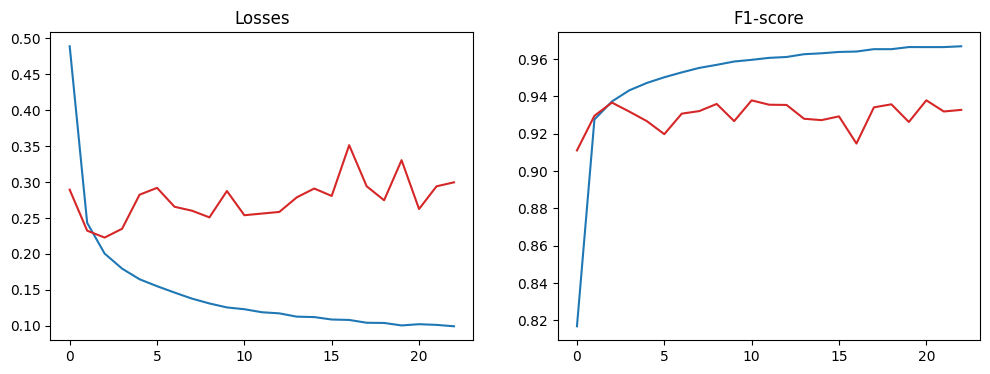

In [50]:
history_keys = list(his.history.keys())

# Создаем подграфики
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 строка, 3 столбца

# Строим графики
axs[0].plot(his.history['loss'], color='tab:blue')
axs[0].plot(his.history['val_loss'], color='tab:red')
axs[0].set_title('Losses')

axs[1].plot(his.history[history_keys[1]], color='tab:blue')
axs[1].plot(his.history[history_keys[3]], color='tab:red')
axs[1].set_title('F1-score')

# Отображаем графики
plt.show()

## Prediction

In [51]:
%%time
y_pred_train_nn = m.predict(X_train_nn)
y_pred_test_nn = m.predict(X_test_nn)

preds_train = np.argmax(y_pred_train_nn, axis=2)[:, 0]
preds_test = np.argmax(y_pred_test_nn, axis=2)[:, 0]

185/185 [==============================] - 0s 2ms/step
CPU times: total: 4.17 s
Wall time: 2.39 s


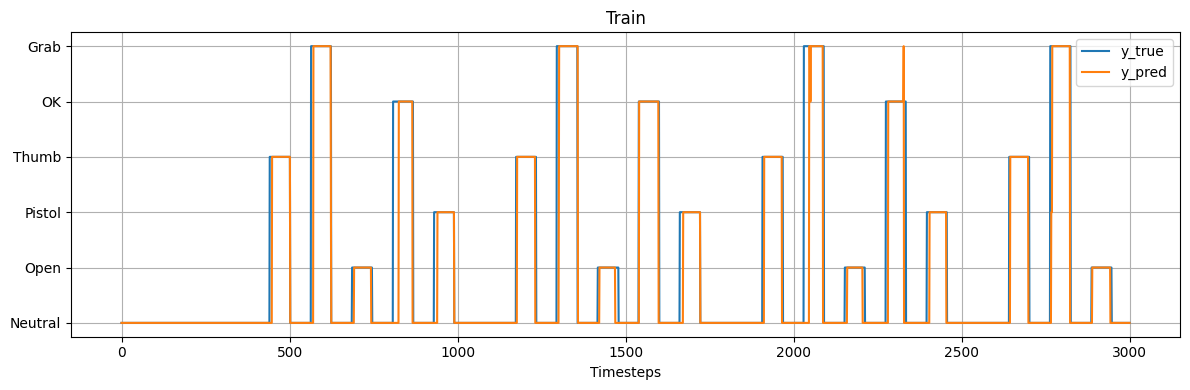

In [52]:
fig = plt.figure(figsize=(12, 4))
plt.plot(y_train[:3000],  c='C0', label='y_true')
plt.plot(preds_train[:3000], c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

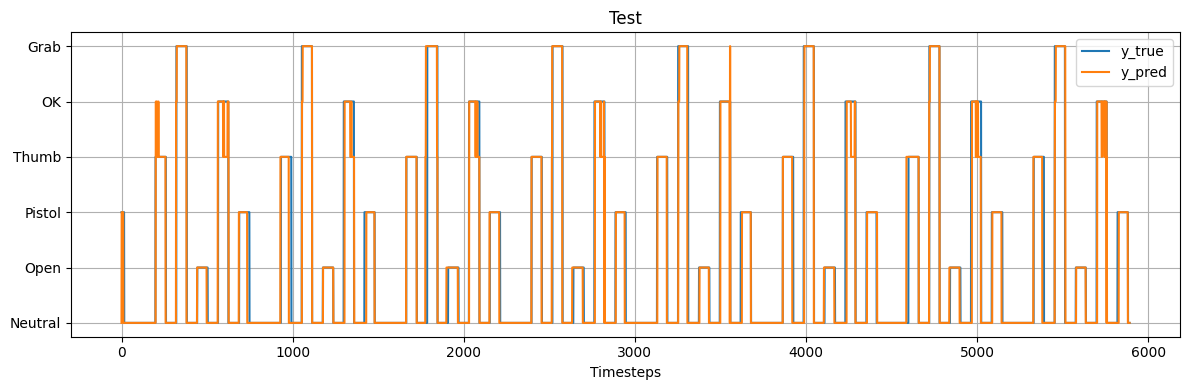

In [53]:
fig = plt.figure(figsize=(12, 4))
plt.plot(y_test, c='C0', label='y_true')
plt.plot(preds_test, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [54]:
print('Train preds metrics report:')
print(metrics.classification_report(
    y_train, preds_train, target_names=GESTURES, digits=4))
print('-'*55)
print('Test preds metrics report:')
print(metrics.classification_report(
    y_test, preds_test, target_names=GESTURES, digits=4))

# создаём таблицу сопряжённости
ct = pd.crosstab(y_test, preds_test)
# определяем название активностей
ct.index = ct.columns = GESTURES
ct

Train preds metrics report:
              precision    recall  f1-score   support

     Neutral     0.9213    0.9902    0.9545     12303
        Open     0.9611    0.8890    0.9236      1694
      Pistol     0.9830    0.8583    0.9164      1680
       Thumb     0.9622    0.8718    0.9148      1693
          OK     0.9577    0.8156    0.8809      1692
        Grab     0.9770    0.8790    0.9254      1694

    accuracy                         0.9383     20756
   macro avg     0.9604    0.8840    0.9193     20756
weighted avg     0.9404    0.9383    0.9373     20756

-------------------------------------------------------
Test preds metrics report:
              precision    recall  f1-score   support

     Neutral     0.9456    0.9775    0.9613      3467
        Open     0.9455    0.9280    0.9367       486
      Pistol     0.9839    0.8574    0.9163       498
       Thumb     0.7122    0.9050    0.7971       484
          OK     0.9058    0.6234    0.7385       478
        Grab     0.96

,Neutral,Open,Pistol,Thumb,OK,Grab
Neutral,3389,26,7,27,6,12
Open,35,451,0,0,0,0
Pistol,71,0,427,0,0,0
Thumb,42,0,0,438,4,0
OK,32,0,0,146,298,2
Grab,15,0,0,4,21,439


---
---
---
---
---

# ONNX

In [56]:
import onnx
import tf2onnx
import onnxruntime

In [57]:
onnx_model, _ = tf2onnx.convert.from_keras(model=m)
onnx.save_model(proto=onnx_model, f='model.onnx')
sess = onnxruntime.InferenceSession(path_or_bytes='model.onnx')
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

# Real-time inference

In [58]:
import time
from serial import Serial
from IPython.display import clear_output

In [59]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [61]:
def preprocessing(x, prev, M=10, tau=3, sym=True):
    # x - sample vector
    if prev is None:
        x = np.delete(x.reshape(1, -1), features_to_remove, axis=1)
        x_scaled = std_scaler.transform(x)
        x_pca = pca.transform(x_scaled)
        prev = np.zeros((LOOK_BACK_NUM, x.shape[-1]))
        prev[0, :] = x_pca
        prev_convolved = get_convolve(prev, M=M, tau=tau, sym=sym)
        y = prev_convolved.reshape(prev.shape[0], prev.shape[1])
    else:
        x = np.delete(x.reshape(1, -1), features_to_remove, axis=1)
        x_scaled = std_scaler.transform(x)
        x_pca = pca.transform(x_scaled)
        prev[1:, :] = prev[:-1, :]
        prev[0, :] = x_pca
        prev_convolved = get_convolve(prev, M=M, tau=tau, sym=sym)
        y = prev_convolved.reshape(prev.shape[0], prev.shape[1])

    return y, prev


def inference(x):
    y = sess.run(output_names=[output_name], input_feed={input_name: [x]})
    y = np.argmax(y, axis=2)[:, 0]
    return np.array([np.argmax(y)])
    # x = np.expand_dims(x, axis=0)
    # pred = m.predict(x)
    # y = np.argmax(pred, axis=2)[:, 0]
    # return y


def postprocessing(x, prev, length=5):
    if prev is None:
        prev = np.zeros((length,))
        prev[1:] = prev[:-1]
        prev[0] = x
        prev = prev.astype(int)
        counts = np.bincount(prev)
        y = np.argmax(counts)
    else:
        prev[1:] = prev[:-1]
        prev[0] = x
        prev = prev.astype(int)
        counts = np.bincount(prev)
        y = np.argmax(counts)
    return y, prev


def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [62]:
df_sim = gestures.iloc[last_train_idx:]
print(df_sim.shape)

(5892, 65)


In [63]:
M, TAU, SYM = 10, 1, False
LENGTH = 2

In [64]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

ts_diffs = []
x_previous = None
y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
    
    # [Data preprocessing]
    sample_preprocessed, x_previous = preprocessing(omg_sample, x_previous, M=M, tau=TAU, sym=SYM)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed, y_previous = postprocessing(y_predicted, y_previous, length=LENGTH)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    # y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), f'Calculation cycle takes more than TIMEOUT, halting...\ntime:{ts_diff}'
    ts_old = ts_start
    ts_diffs.append(ts_diff)
    i += 1 

In [65]:
np.max(ts_diffs)

0.009002447128295898

In [66]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (5892, 50)
enc_sample.shape = (5892, 6)
sample_preprocessed.shape = (5892, 10, 46)
y_predicted.shape = (5892, 1)
y_postprocessed.shape = (5892,)
y_commands.shape = (5892,)


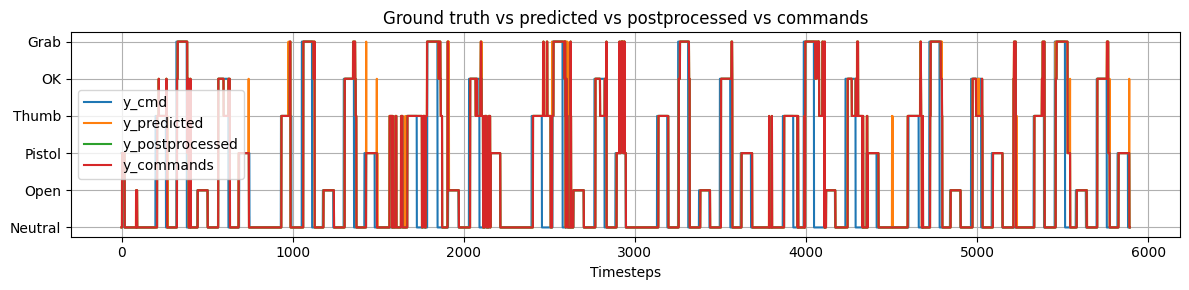

In [67]:
fig = plt.figure(figsize=(12, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [68]:
print(metrics.classification_report(
    y_test, y_dct['y_commands'], target_names=GESTURES, digits=4
))

# создаём таблицу сопряжённости
ct = pd.crosstab(y_test, y_dct['y_commands'].reshape(-1,))
# определяем название активностей
ct.index = ct.columns = GESTURES
ct

              precision    recall  f1-score   support

     Neutral     0.9267    0.8131    0.8662      3467
        Open     0.9536    0.9300    0.9417       486
      Pistol     0.8462    0.8614    0.8537       498
       Thumb     0.4760    0.8595    0.6127       484
          OK     0.7279    0.6213    0.6704       478
        Grab     0.7104    0.8706    0.7824       479

    accuracy                         0.8198      5892
   macro avg     0.7735    0.8260    0.7878      5892
weighted avg     0.8514    0.8198    0.8278      5892



,Neutral,Open,Pistol,Thumb,OK,Grab
Neutral,2819,22,78,313,91,144
Open,33,452,0,0,0,1
Pistol,49,0,429,12,0,8
Thumb,52,0,0,416,4,12
OK,53,0,0,123,297,5
Grab,36,0,0,10,16,417


### Online (prosthesis or virtual hand)

In [ ]:
# TIMEOUT = 0.033
# DEBUG = True

# ser = None
# ser_port = None
# # ser_port = '/dev/ttyACM0'
# # ser_port = '/dev/cu.usbmodem3498365F31351'

# if ser_port is not None:
#     ser = Serial(port=ser_port, timeout=2*TIMEOUT)
#     ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
#     ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
#     ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

#     # flush buffers
#     ser.reset_input_buffer()
#     ser.read()
    
#     i = 0;
#     while(ser.in_waiting):
#         print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
#         ser.read_all()
#         time.sleep(0.005)
#         i+=1;
#     ser.readline()
#     ser.readline()
    
# i = 0
# ts_old = time.time()
# ts_diff = 0;

# y_previous = None
# while True:    
    
#     # [Data reading]
#     s = ser.readline()
#     ts_start = time.time()
    
#     try:
#         sample = np.array(s.decode('UTF-8')\
#                            .replace('\r\n', "")\
#                            .split(' ')
#                          ).astype(int)
#         [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
#     except Exception as e:
#         print(e)
        
#     # [/Data Reading]
        
#     # [Data preprocessing]
#     sample_preprocessed = preprocessing(omg_sample)
#     # [/Data preprocessing]
    
#     # [Inference]
#     y_predicted         = inference(sample_preprocessed)
#     # [/Inference]
    
#     # [Inference Postprocessing]
#     y_postprocessed     = postprocessing(y_predicted, y_previous)
#     # [/Inference Postprocessing]
    
#     # [Commands composition]
#     y_commands          = commands(y_postprocessed)
#     # [/Commands composition]
    
#     # [Commands sending]
#     pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
#     # [/Commands sending]
    
#     y_previous = y_postprocessed
    
#     if DEBUG:
#         clear_output(wait=True)

#         # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
#         print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
#         print('INPUT:\n', s)

#         # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
#         print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
#         print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
#         print(y_commands)
#         print(pack)
    
#     ts_diff = time.time() - ts_start
#     assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
#     ts_old = ts_start
#     i += 1 